In [0]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
from tensorflow import feature_column
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
import seaborn as sns
import sklearn.svm as svm

In [3]:
# upload theorem CSV
from google.colab import files
uploaded = files.upload()

Saving thms.csv to thms.csv


In [99]:
# load the theorems, provided the uploaded file was called "thms.csv"
import io

BATCH_SIZE = 256

thm_df = tf.data.experimental.make_csv_dataset(
    'thms.csv', BATCH_SIZE, label_name='is_proven', num_epochs=1)

# load it in this form too for convenience
stmts_df = pd.read_csv('thms.csv')

# generate vocabulary
vocab = set(" ".join(stmts_df['stmt']))
vocab.remove(" ")
vocab.remove("x")
vocab = list(vocab)
print(vocab)

[')', '0', 'e', ',', 'i', '*', '3', '(', '4', '=', '2', '1']


In [0]:
# train test split

TEST_SIZE = 2
test_df = thm_df.take(TEST_SIZE)
train_df = thm_df.skip(TEST_SIZE).repeat()


In [0]:
feature_cols = []

feature_cols.append(feature_column.numeric_column('time_agg'))
feature_cols.append(feature_column.numeric_column('max_mem_agg'))
feature_cols.append(feature_column.numeric_column('num_exp_agg'))
feature_cols.append(feature_column.numeric_column('num_attempts'))

stmt_col = feature_column.embedding_column(
    feature_column.sequence_categorical_column_with_vocabulary_list('stmt',
    vocab), dimension=4)

In [0]:
inputs_num = {
    colname : tf.keras.layers.Input(name=colname, shape=(), dtype='float32') \
          for colname in ['time_agg', 'max_mem_agg', 'num_exp_agg', 'num_attempts']
}
inputs_txt = {
    'stmt' : tf.keras.layers.Input(name='stmt', shape=(), dtype='string')
}
all_inputs = dict(inputs_num)
all_inputs.update(inputs_txt)

features_num = tf.keras.layers.DenseFeatures(feature_cols)(inputs_num)
features_txt, features_txt_len = tf.keras.experimental.SequenceFeatures([stmt_col])(inputs_txt)
features_txt_len_msk = tf.sequence_mask(features_txt_len)

# LSTM
txt_node = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,
    dropout=0.5, kernel_regularizer=tf.keras.regularizers.l2(1.0e-3),
    return_sequences=True, activation=None))(features_txt, mask=features_txt_len_msk)

txt_node = tf.keras.layers.BatchNormalization()(txt_node)
txt_node = tf.keras.layers.Activation('relu')(txt_node)
txt_node = tf.keras.layers.Dropout(0.5)(txt_node)

txt_node = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,
    dropout=0.5, kernel_regularizer=tf.keras.regularizers.l2(1.0e-3),
    activation=None))(txt_node, mask=features_txt_len_msk)

txt_node = tf.keras.layers.BatchNormalization()(txt_node)
txt_node = tf.keras.layers.Activation('relu')(txt_node)
txt_node = tf.keras.layers.Dropout(0.5)(txt_node)

# incorporate the extra features
middle_layer = tf.keras.layers.Dense(8)(features_num)
middle_layer = tf.keras.layers.Dense(8)(middle_layer)
middle_layer = tf.keras.layers.concatenate([middle_layer, txt_node])

# KL-divergence regularisation to make the output be approximately
# unit normal
# use an "encoded layer" for later
NUM_HIDDEN = 64
encoder_layer = tf.keras.layers.Dense(tfp.layers.MultivariateNormalTriL.params_size(NUM_HIDDEN))(middle_layer)
encoder_layer = tfp.layers.MultivariateNormalTriL(
    NUM_HIDDEN,
    activity_regularizer=tfp.layers.KLDivergenceRegularizer(
        tfp.distributions.MultivariateNormalDiag(loc=tf.zeros(NUM_HIDDEN)),
        weight=1.0e-6))(encoder_layer)

# begin final layer
final_layer = tf.keras.layers.Dense(32,
    kernel_regularizer=tf.keras.regularizers.l2(1.0e-3))(encoder_layer)

final_layer = tf.keras.layers.BatchNormalization()(final_layer)
final_layer = tf.keras.layers.Activation('relu')(final_layer)
final_layer = tf.keras.layers.Dropout(0.5)(final_layer)

final_layer = tf.keras.layers.Dense(32, activation='relu',
    kernel_regularizer=tf.keras.regularizers.l2(1.0e-3))(final_layer)

# output:
final_layer = tf.keras.layers.Dense(1, activation='sigmoid')(final_layer)

model = tf.keras.Model(inputs=all_inputs,
              outputs=final_layer)

model.compile(loss='binary_crossentropy',
              optimizer='Adam',
              metrics=['accuracy', 'AUC'])

# model.summary()

encoder_model = tf.keras.Model(inputs=all_inputs,
    outputs=encoder_layer)
encoder_model.compile()

In [106]:
history = model.fit(train_df, epochs=20,
          validation_data=test_df, steps_per_epoch=100,
          class_weight={ 0 : 0.1, 1 : 0.9 })

Epoch 1/20
100/100 [==============================] - 9s 87ms/step - loss: 19963.3418 - accuracy: 0.3309 - auc: 0.5417 - val_loss: 2495.3218 - val_accuracy: 0.1934 - val_auc: 0.8073
Epoch 2/20
100/100 [==============================] - 7s 72ms/step - loss: 4518.2935 - accuracy: 0.2118 - auc: 0.5941 - val_loss: 1026.5760 - val_accuracy: 0.1602 - val_auc: 0.7087
Epoch 3/20
100/100 [==============================] - 7s 72ms/step - loss: 1216.1422 - accuracy: 0.1993 - auc: 0.6405 - val_loss: 193.3294 - val_accuracy: 0.1406 - val_auc: 0.6228
Epoch 4/20
100/100 [==============================] - 7s 72ms/step - loss: 438.1564 - accuracy: 0.2150 - auc: 0.6645 - val_loss: 504.5995 - val_accuracy: 0.1504 - val_auc: 0.6815
Epoch 5/20
100/100 [==============================] - 7s 72ms/step - loss: 208.5592 - accuracy: 0.2312 - auc: 0.6933 - val_loss: 34.9589 - val_accuracy: 0.1367 - val_auc: 0.7538
Epoch 6/20
100/100 [==============================] - 7s 71ms/step - loss: 87.0755 - accuracy: 0.268

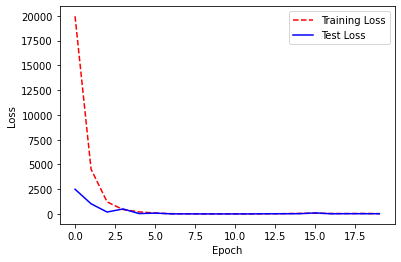

In [107]:
# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Visualize loss history
plt.plot(training_loss, 'r--')
plt.plot(test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [111]:
stmts_df['p_true'] = model.predict(thm_df)
stmts_df.sort_values('p_true', ascending=False).head(25)

(1712, 64)


,stmt,is_proven,time_agg,max_mem_agg,num_exp_agg,num_attempts,p_true
353,"*(i(i(*(e, e))), x0) = x0",1,1.687500,6,10029,2,0.999994
810,"e = *(x0, *(i(x0), e))",1,0.000000,26,24,1,0.915525
679,"e = *(e, *(i(x0), *(*(x0, i(x0)), x0)))",0,2.515630,110,5001,1,0.735958
397,"*(i(x0), x0) = *(i(x0), *(*(e, *(e, x0)), x0))",0,3.765630,80,5001,1,0.734592
578,"e = *(*(*(i(x0), x0), i(x0)), e)",0,96.750030,129,5502,2,0.734558
117,"*(*(x0, e), x1) = *(x0, *(*(i(i(*(*(x1, i(*(*(...",0,11.843750,5,20002,2,0.733955
736,"e = *(i(e), *(e, *(e, *(x0, i(x1)))))",0,8.343750,90,5001,1,0.733696
704,"e = *(i(*(*(x0, i(*(i(*(i(x0), e)), x0))), i(*...",0,3.703130,100,5001,1,0.733668
691,"e = *(e, i(e))",1,0.000000,1,1,1,0.733592
3,"*(*(*(*(e, x0), *(*(i(*(e, i(*(*(e, e), *(i(e)...",0,23.140600,80,35002,2,0.733370
